In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import random

import nltk                         # import NLTK to handle simple NL tasks like tokenization.
nltk.download("punkt")
from nltk.util import ngrams
from collections import Counter     # import the Counter module.
#!pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.

import statistics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Global parameters
#root folder
root_folder='/content/drive/MyDrive/machine-translation/'
#data_folder='.'
data_folder_name='corpus/spa-eng'
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

In [6]:
train_filenamepath

'/content/drive/MyDrive/machine-translation/corpus/spa-eng/spa.txt'

In [7]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 120000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024 #512

BATCH_SIZE = 128  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

ATTENTION_FUNC='general'

In [8]:
#Preprocessing the data
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

In [9]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[TARGET_COLUMN,INPUT_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)

In [10]:
df

,target,input
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
119995,What happened to the book I put here yesterday?,¿Qué le pasó al libro que dejé aquí ayer?
119996,What on earth do you want to talk to Tom about?,¿De qué diablos quieres hablar con Tom?
119997,What time was it when you entered the building?,¿Qué hora era cuando entraste en el edificio?
119998,What we want to do next is check the oil level.,Lo que queremos hacer es medir el nivel de ace...


In [11]:
train, test = train_test_split(df, test_size=0.2)

In [12]:
train

,target,input
114938,Tom and Mary finally decided to get married.,Tom y Mary finalmente decidieron casarse.
90791,I realized that that box was empty.,Me di cuenta de que esa caja estaba vacía.
41806,I haven't forgotten her.,No la he olvidado.
36909,I know what I'm saying.,Yo sé lo que estoy diciendo.
48529,This article is for sale.,Este artículo está a la venta.
...,...,...
100610,I've been waiting for her for an hour.,La estoy esperando hace una hora.
97108,I don't want to go to lunch with Tom.,No quiero ir a almorzar con Tom.
98645,Tom can't find what he's looking for.,Tom no puede encontrar lo que está buscando.
34874,We left him some cake.,Le dejamos un poco de tarta.


In [13]:
test

,target,input
59403,Can't you make up your mind?,¿No puedes decidirte?
85135,Tom offered Mary a glass of wine.,Tomás le ofreció una copa de vino a María.
64613,He can speak Russian as well.,Él también puede hablar ruso.
103334,I've been trying to get your attention.,He estado tratando de captar tu atención.
31337,Do you like that song?,¿Te gusta esta canción?
...,...,...
66963,That's almost the same thing.,Es casi la misma cosa.
116823,Tom was quite good-looking when he was young.,Tom era bastante lindo cuando era joven.
65633,I once knew someone like you.,Una vez conocí a alguien como tú.
9692,I'll let Tom go.,Dejaré ir a Tom.


In [14]:
# Preprocess the input data
input_data=train[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=train[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is right shifted
target_input_data=train[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:3])
print(target_data[:3])
print(target_input_data[:3])

['tom y mary finalmente decidieron casarse .', 'me di cuenta de que esa caja estaba vacia .', 'no la he olvidado .']
['tom and mary finally decided to get married . <eos>', 'i realized that that box was empty . <eos>', 'i haven t forgotten her . <eos>']
['<sos> tom and mary finally decided to get married .', '<sos> i realized that that box was empty .', '<sos> i haven t forgotten her .']


In [15]:
# Create a tokenizer for the input texts(Spanish) and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[19995])
print(input_sequences[19995])


Max Input Length:  20
no se movio nadie .
[4, 15, 3729, 95, 1]


In [16]:
# tokenize the outputs(English)
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[19995])
print(target_sequences[19995])
print(target_input_data[19995])
print(target_sequences_inputs[19995])

Max Target Length:  16
no one moved . <eos>
[70, 74, 902, 1, 2]
<sos> no one moved .
[3, 70, 74, 902, 1]


In [17]:
#Creating Vocabularies
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 20977 unique input tokens.
Found 10944 unique output tokens.


In [18]:
#Padding - necessary to pad the sentences with 0 at the end so all the sentences have the smae length
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (96000, 20)
encoder_inputs[0]: [   5   37   28  850 2510 1324    1    0    0    0    0    0    0    0
    0    0    0    0    0    0]
decoder_inputs[0]: [  3   8  50  35 721 427   7  67 260   1   0   0   0   0   0   0]
decoder_inputs.shape: (96000, 16)


In [19]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(input_data)).batch(
    BATCH_SIZE, drop_remainder=True)

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(embed, state)
        # Dense layer to predict output token
        logits = self.dense(lstm_out)

        return logits, state_h, state_c

In [22]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
initial_state = encoder.init_states(1)
# Call the encoder for testing
test_encoder_output = encoder(tf.constant(
    [[1, 23, 4, 5, 0, 0]]), initial_state)
print(test_encoder_output[0].shape)
# Create the decoder
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
de_initial_state = test_encoder_output[1:]
# Call the decoder for testing
test_decoder_output = decoder(tf.constant(
    [[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)
print(test_decoder_output[0].shape)

(1, 6, 1024)
(1, 8, 10945)


In [23]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [24]:
# Use the @tf.function decorator to take advance of static graph computation
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        # Set the encoder and decoder states
        en_states = en_outputs[1:]
        de_states = en_states
        # Get the encoder outputs
        de_outputs = decoder(target_seq_in, de_states)
        # Take the actual output
        logits = de_outputs[0]
        # Calculate the loss function
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

In [25]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [27]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/machine-translation/models/spa-eng/training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 4.6415 Acc:0.0000
Epoch 1 Batch 100 Loss 2.3900 Acc:0.2817
Epoch 1 Batch 200 Loss 2.1493 Acc:0.2995
Epoch 1 Batch 300 Loss 2.1080 Acc:0.3242
Epoch 1 Batch 400 Loss 1.9340 Acc:0.3732
Epoch 1 Batch 500 Loss 1.8414 Acc:0.3710
Epoch 1 Batch 600 Loss 1.7714 Acc:0.3794
Epoch 1 Batch 700 Loss 1.6927 Acc:0.3862
Time taken for 1 epoch 105.7384 sec

Epoch 2 Batch 0 Loss 1.7889 Acc:0.3851
Epoch 2 Batch 100 Loss 1.7638 Acc:0.3832
Epoch 2 Batch 200 Loss 1.5989 Acc:0.3897
Epoch 2 Batch 300 Loss 1.6811 Acc:0.3990
Epoch 2 Batch 400 Loss 1.7086 Acc:0.3898
Epoch 2 Batch 500 Loss 1.7565 Acc:0.3915
Epoch 2 Batch 600 Loss 1.6338 Acc:0.4223
Epoch 2 Batch 700 Loss 1.5318 Acc:0.4238
Time taken for 1 epoch 105.5648 sec

Epoch 3 Batch 0 Loss 1.5467 Acc:0.4200
Epoch 3 Batch 100 Loss 1.4642 Acc:0.4662
Epoch 3 Batch 200 Loss 1.4752 Acc:0.4577
Epoch 3 Batch 300 Loss 1.4620 Acc:0.4638
Epoch 3 Batch 400 Loss 1.3383 Acc:0.4935
Epoch 3 Batch 500 Loss 1.3900 Acc:0.4844
Epoch 3 Batch 600 Loss 1.3527 

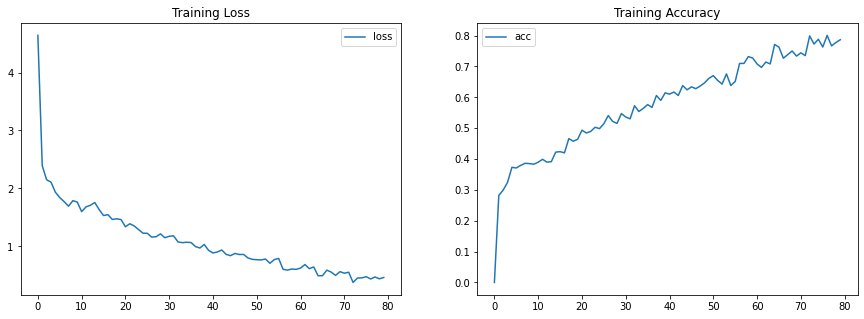

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = '/content/drive/MyDrive/machine-translation/models/spa-eng/training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [54]:
predicted_list = []

In [35]:
def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
        #print(input_text)
    # Tokenize the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    #print(input_seq)
    # Set the encoder initial state
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Create the decoder input, the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)
        # Append the word to the predicted output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Finish when eos token is found or the max length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break
    out_words = ' '.join(out_words)
    predicted_list.append(out_words)
    #print('Predicted English Text - ',' '.join(out_words))
    return predicted_list

In [36]:
# Preprocess the input data
input_data_test = test[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data_test = test[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is right shifted
target_input_data_test = test[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()
print(input_data_test[:10])
print(target_data_test[:10])
print(target_input_data_test[:10])


['¿ no puedes decidirte ?', 'tomas le ofrecio una copa de vino a maria .', 'el tambien puede hablar ruso .', 'he estado tratando de captar tu atencion .', '¿ te gusta esta cancion ?', 'esta habitacion tiene tres ventanas .', 'aqui tienes los documentos que pediste .', 'me gusta esta taza .', 'alguien la visito ayer .', '¿ lo recuerdas ?']
['can t you make up your mind ? <eos>', 'tom offered mary a glass of wine . <eos>', 'he can speak russian as well . <eos>', 'i ve been trying to get your attention . <eos>', 'do you like that song ? <eos>', 'this room has three windows . <eos>', 'here are the documents you asked for . <eos>', 'i like this cup . <eos>', 'someone visited her yesterday . <eos>', 'do you remember ? <eos>']
['<sos> can t you make up your mind ?', '<sos> tom offered mary a glass of wine .', '<sos> he can speak russian as well .', '<sos> i ve been trying to get your attention .', '<sos> do you like that song ?', '<sos> this room has three windows .', '<sos> here are the docu

In [37]:
#zipped_list = list(zip(input_data_test, target_data_test))
#test_sent = random.sample(zipped_list, 20)
#for test_sent in test_sent:
 #   print('Input Spanish Text - ', test_sent)
 #   predict(test_sent, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)
 #   print('\n')
#print(len(input_data_test))

for test_sent, test_output in zip(input_data_test[:10], target_data_test[:10]):
    print('Input Spanish Text - ', test_sent)
    print('Target English Text - ', test_output)
    predict(test_sent, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)
    print('\n')

Input Spanish Text -  ¿ no puedes decidirte ?
Target English Text -  can t you make up your mind ? <eos>


Input Spanish Text -  tomas le ofrecio una copa de vino a maria .
Target English Text -  tom offered mary a glass of wine . <eos>


Input Spanish Text -  el tambien puede hablar ruso .
Target English Text -  he can speak russian as well . <eos>


Input Spanish Text -  he estado tratando de captar tu atencion .
Target English Text -  i ve been trying to get your attention . <eos>


Input Spanish Text -  ¿ te gusta esta cancion ?
Target English Text -  do you like that song ? <eos>


Input Spanish Text -  esta habitacion tiene tres ventanas .
Target English Text -  this room has three windows . <eos>


Input Spanish Text -  aqui tienes los documentos que pediste .
Target English Text -  here are the documents you asked for . <eos>


Input Spanish Text -  me gusta esta taza .
Target English Text -  i like this cup . <eos>


Input Spanish Text -  alguien la visito ayer .
Target Englis

In [55]:
predicted_list

[]

In [56]:
for test_sent, test_output in zip(input_data_test[:10000], target_data_test[:10000]):
    predict(test_sent, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

In [57]:
print(len(predicted_list))
predicted_list[:10]

10000


['can t you lift it ? <eos>',
 'tom offered mary a present . <eos>',
 'he can swim , but i don t . <eos>',
 'i ve been trying to get you all . <eos>',
 'do you like this garden ? <eos>',
 'this room has three rooms . <eos>',
 'you have only one of your own mind . <eos>',
 'i like this movie . <eos>',
 'somebody knocked on the door . <eos>',
 'do you remember me ? <eos>']

In [58]:
print(len(target_data_test))
target_data_test[:10]

24000


['can t you make up your mind ? <eos>',
 'tom offered mary a glass of wine . <eos>',
 'he can speak russian as well . <eos>',
 'i ve been trying to get your attention . <eos>',
 'do you like that song ? <eos>',
 'this room has three windows . <eos>',
 'here are the documents you asked for . <eos>',
 'i like this cup . <eos>',
 'someone visited her yesterday . <eos>',
 'do you remember ? <eos>']

In [45]:
#BLEU SCORE using our own function
#Bleu = Brevity Penalty * precision
def brevity_penalty(reference, candidate):
    ref_length = len(reference)
    can_length = len(candidate)

    # Brevity Penalty
    if ref_length > can_length:
        BP = 1
    else:
        penalty = 1 - (ref_length / can_length)
        BP = np.exp(penalty)

    return BP

In [46]:
def clipped_precision(reference, candidate):
    """
    Bleu score function given a original and a machine translated sentences
    """

    clipped_precision_score = []

    for i in range(1, 5):
        candidate_n_gram = Counter(
            ngrams(candidate, i)
        )  # counts of n-gram n=1...4 tokens for the candidate
        reference_n_gram = Counter(
            ngrams(reference, i)
        )  # counts of n-gram n=1...4 tokens for the reference

        c = sum(
            reference_n_gram.values()
        )  # sum of the values of the reference the denominator in the precision formula

        for j in reference_n_gram:  # for every n_gram token in the reference
            if j in candidate_n_gram:  # check if it is in the candidate n-gram

                if (
                    reference_n_gram[j] > candidate_n_gram[j]
                ):  # if the count of the reference n-gram is bigger
                    # than the corresponding count in the candidate n-gram
                    reference_n_gram[j] = candidate_n_gram[
                        j
                    ]  # then set the count of the reference n-gram to be equal
                    # to the count of the candidate n-gram
            else:

                reference_n_gram[j] = 0  # else reference n-gram = 0

        clipped_precision_score.append(sum(reference_n_gram.values()) / c)

    weights = [0.25] * 4

    s = (w_i * np.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = np.exp(np.sum(s))
    return s

In [47]:
def bleu_score(reference, candidate):
    BP = brevity_penalty(reference, candidate)
    precision = clipped_precision(reference, candidate)
    return BP * precision

In [62]:
#Word Tokenizing every element in the reference and candidate list
bleu = []
for tokenized_ref, tokenized_can in zip(target_data_test[:10000], predicted_list): 
    score = round(bleu_score(tokenized_ref, tokenized_can) * 100, 1)
    bleu.append(score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [63]:
statistics.mean(bleu)

58.86159

In [64]:
#SacreBleu Score
#Word Tokenizing every element in the reference and candidate list
bleu_score = []
for tokenized_ref, tokenized_can in zip(target_data_test, predicted_list): 
    score = round(sacrebleu.corpus_bleu(tokenized_ref, tokenized_can).score, 1)
    bleu_score.append(score)

In [65]:
statistics.mean(bleu_score)

40.659

In [67]:
#Not sure if correct. might have some error
from nltk.translate.bleu_score import sentence_bleu
nltk_bleu_score = []
for tokenized_ref, tokenized_can in zip(target_data_test, predicted_list): 
    score = sentence_bleu(tokenized_ref, tokenized_can)
    nltk_bleu_score.append(score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [68]:
statistics.mean(nltk_bleu_score)

0.8093876948110793